In [16]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import cross_val_score, StratifiedKFold, ParameterGrid
import time
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import time

# Hyperparameter tuning

In [17]:
# code referenced from group work

# load data
df = pd.read_csv('contraceptive_data.csv')

# set features to x variable
x = df[['wife_age','wife_edu', 'husband_edu', 'num_children', 'wife_religion', 'wife_working','husband_occupation',
       'standard_of_living_index', 'media_exposure']].values  

# set targets to y variable
y = df['contraceptive_method'].values  

# convert to one-hot encoded labels
y = pd.get_dummies(y).values  

# split dataset into 80% training set and 20% testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# set random seed for reproducibility
torch.manual_seed(42)


# define the mlp model
class contraceptiveNN(nn.Module):
    def __init__(self, hidden1,hidden2): # constructor method for contructiveNN class with hidden neuron sizes as params
        super(contraceptiveNN, self).__init__() # constructor method for parent class to initialize
        self.fc1 = nn.Linear(9, hidden1) # fully connected linear layer, takes 9 inputs
        self.fc2 = nn.Linear(hidden1, hidden2)  # second fully connected linear layer
        self.fc3 = nn.Linear(hidden2, 3) # third linear layer
        #self.fc4 = nn.Linear(hidden3, hidden4)
        #self.fc5 = nn.Linear(hidden4, hidden5)
        #self.fc6 = nn.Linear(hidden5, 3)
        self.relu = nn.ReLU() # rectified linear unit activation function
        self.softmax = nn.Softmax(dim=1) # softmax layer for classification task

    # implement forward pass    
    def forward(self, x):
        x = self.fc1(x) # applies first fully connected linear layer to input x
        x = self.relu(x) # applies relu activation function to output of fc1
        x = self.fc2(x) # applies fc2  to x
        x = self.relu(x) # apply relu activation function
        x = self.fc3(x) # apply fc3 to x
        #x = self.relu(x)
        #x = self.fc4(x)
        #x = self.relu(x)
        #x = self.fc5(x)
        #x = self.relu(x)
        #x = self.fc6(x)
        x = self.softmax(x)  # apply softmax
        return x # returns output
    

# create cross entropy loss function
criterion = nn.CrossEntropyLoss()  

# parameters for grid search
gridsearch = {
    'hidden_size1': [60, 70, 80, 90],
    'hidden_size2': [60, 70, 80, 90],
    #'hidden_size1': [9,15,17],
    #'hidden_size2': [9,15,17],
    #'hidden_size3': [9,15,17],
    #'hidden_size4': [9,15,17],
    #'hidden_size5': [9,15,17],
    'learning_rate': [0.0001,0.001, 0.01, 0.1, 0.5],
    #'momentum': [0.0, 0.5, 0.9, 0.99],  # 
    'weight_decay': [0.0, 0.001, 0.01, 0.1, 0.2]  # weight decay values for L2 regularization
}

# k fold for cross validation 
num_epochs = 500
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# variables to keep track of accuracy and training time
best_accuracy = 0
best_params = None
total_training_time = 0

# cross validation with grid search for best hyperparameters
for params in ParameterGrid(gridsearch):
    print(f"Trying parameters: {params}")
    total_accuracy = 0 # initialize accuracy var for current set of hidden neuron size and learning rate
    torch.manual_seed(42)

    # iterate through each fold for training and validation
    for fold, (trainIdx, valIdx) in enumerate(skf.split(x_train, y_train.argmax(axis=1))):
        # split train and validation data for each k fold
        x_train_fold = x_train[trainIdx]
        y_train_fold = y_train[trainIdx]
        x_val_fold = x_train[valIdx]
        y_val_fold = y_train[valIdx]

        # wrap in tensor
        x_train_fold = torch.tensor(x_train_fold, dtype=torch.float32) 
        y_train_fold = torch.tensor(y_train_fold.argmax(axis=1), dtype=torch.long)
        x_val_fold = torch.tensor(x_val_fold, dtype=torch.float32)
        y_val_fold = torch.tensor(y_val_fold.argmax(axis=1), dtype=torch.long)

        # call contraceptiveNN class with current hidden neuron sizes
        model = contraceptiveNN(hidden1=params['hidden_size1'], hidden2=params['hidden_size2'])
        
        # implement adam optimizer with current learning rate and weight decay
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], 
                              weight_decay=params['weight_decay'])

        start_time = time.time() # start recording time for training
        
        # code reference from lab
        # iterate through each epoch
        for epoch in range(num_epochs):
            # implement backpropagation
            optimizer.zero_grad()
            y_pred = model(x_train_fold)
            loss = criterion(y_pred, y_train_fold)
            loss.backward()
            optimizer.step()
    
        end_time = time.time() # end time for training
        total_training_time = total_training_time + (end_time - start_time) # get total training time

        # evaluation on the current fold
        # calculate validation loss
        val_outputs = model(x_val_fold)
        val_loss = criterion(val_outputs, y_val_fold)

        # code reference: https://www.coursehero.com/tutors-problems/Python-Programming/57651004-I-am-trying-to-modify-this-LSTM-model-to-make-it-work-with-this/
        # calculate accuracy
        _, predicted = torch.max(val_outputs, 1)
        correct = (predicted == y_val_fold).sum().item()
        total = y_val_fold.size(0)
        accuracy = correct / total
        total_accuracy = total_accuracy + accuracy

        print(f'Fold {fold+1}, Validation Loss: {val_loss.item()}, Accuracy: {accuracy}')

    avg_accuracy = total_accuracy / k_folds
    print(f"Average Accuracy for parameters {params}: {avg_accuracy}")

    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_params = params

print(f"Best Parameters: {best_params}, Best Accuracy: {best_accuracy}")
print(f"Average Training Time per fold: {total_training_time / (k_folds * len(ParameterGrid(gridsearch)))} seconds")


Trying parameters: {'hidden_size1': 60, 'hidden_size2': 60, 'learning_rate': 0.0001, 'weight_decay': 0.0}
Fold 1, Validation Loss: 1.0190070867538452, Accuracy: 0.5092838196286472
Fold 2, Validation Loss: 1.0298060178756714, Accuracy: 0.4827586206896552
Fold 3, Validation Loss: 0.9843946099281311, Accuracy: 0.5623342175066313
Fold 4, Validation Loss: 0.9982057213783264, Accuracy: 0.5411140583554377
Fold 5, Validation Loss: 0.9939278960227966, Accuracy: 0.5345744680851063
Average Accuracy for parameters {'hidden_size1': 60, 'hidden_size2': 60, 'learning_rate': 0.0001, 'weight_decay': 0.0}: 0.5260130368530955
Trying parameters: {'hidden_size1': 60, 'hidden_size2': 60, 'learning_rate': 0.0001, 'weight_decay': 0.001}
Fold 1, Validation Loss: 1.018587350845337, Accuracy: 0.5145888594164456
Fold 2, Validation Loss: 1.0278279781341553, Accuracy: 0.4827586206896552
Fold 3, Validation Loss: 0.988789439201355, Accuracy: 0.5464190981432361
Fold 4, Validation Loss: 1.0022811889648438, Accuracy: 0.

Fold 3, Validation Loss: 1.063986897468567, Accuracy: 0.4270557029177719
Fold 4, Validation Loss: 1.0679501295089722, Accuracy: 0.4244031830238727
Fold 5, Validation Loss: 1.064261794090271, Accuracy: 0.425531914893617
Average Accuracy for parameters {'hidden_size1': 60, 'hidden_size2': 60, 'learning_rate': 0.01, 'weight_decay': 0.1}: 0.42622044133416115
Trying parameters: {'hidden_size1': 60, 'hidden_size2': 60, 'learning_rate': 0.01, 'weight_decay': 0.2}
Fold 1, Validation Loss: 1.075001835823059, Accuracy: 0.4270557029177719
Fold 2, Validation Loss: 1.076393723487854, Accuracy: 0.4270557029177719
Fold 3, Validation Loss: 1.0734134912490845, Accuracy: 0.4270557029177719
Fold 4, Validation Loss: 1.0751566886901855, Accuracy: 0.4244031830238727
Fold 5, Validation Loss: 1.0735688209533691, Accuracy: 0.425531914893617
Average Accuracy for parameters {'hidden_size1': 60, 'hidden_size2': 60, 'learning_rate': 0.01, 'weight_decay': 0.2}: 0.42622044133416115
Trying parameters: {'hidden_size1'

Fold 1, Validation Loss: 1.0345685482025146, Accuracy: 0.4960212201591512
Fold 2, Validation Loss: 1.0326952934265137, Accuracy: 0.4827586206896552
Fold 3, Validation Loss: 1.0051625967025757, Accuracy: 0.5278514588859416
Fold 4, Validation Loss: 1.0200992822647095, Accuracy: 0.5013262599469496
Fold 5, Validation Loss: 1.0070159435272217, Accuracy: 0.5159574468085106
Average Accuracy for parameters {'hidden_size1': 60, 'hidden_size2': 70, 'learning_rate': 0.0001, 'weight_decay': 0.01}: 0.5047830012980417
Trying parameters: {'hidden_size1': 60, 'hidden_size2': 70, 'learning_rate': 0.0001, 'weight_decay': 0.1}
Fold 1, Validation Loss: 1.059706687927246, Accuracy: 0.4270557029177719
Fold 2, Validation Loss: 1.054903268814087, Accuracy: 0.41644562334217505
Fold 3, Validation Loss: 1.0521049499511719, Accuracy: 0.4270557029177719
Fold 4, Validation Loss: 1.0530943870544434, Accuracy: 0.4323607427055703
Fold 5, Validation Loss: 1.0459426641464233, Accuracy: 0.42819148936170215
Average Accura

Fold 5, Validation Loss: 1.1977214813232422, Accuracy: 0.3537234042553192
Average Accuracy for parameters {'hidden_size1': 60, 'hidden_size2': 70, 'learning_rate': 0.1, 'weight_decay': 0.0}: 0.4118587392065015
Trying parameters: {'hidden_size1': 60, 'hidden_size2': 70, 'learning_rate': 0.1, 'weight_decay': 0.001}
Fold 1, Validation Loss: 1.1986597776412964, Accuracy: 0.35278514588859416
Fold 2, Validation Loss: 1.1243891716003418, Accuracy: 0.4270557029177719
Fold 3, Validation Loss: 1.1986597776412964, Accuracy: 0.35278514588859416
Fold 4, Validation Loss: 1.1270416975021362, Accuracy: 0.4244031830238727
Fold 5, Validation Loss: 1.1259129047393799, Accuracy: 0.425531914893617
Average Accuracy for parameters {'hidden_size1': 60, 'hidden_size2': 70, 'learning_rate': 0.1, 'weight_decay': 0.001}: 0.39651221852248997
Trying parameters: {'hidden_size1': 60, 'hidden_size2': 70, 'learning_rate': 0.1, 'weight_decay': 0.01}
Fold 1, Validation Loss: 1.018175482749939, Accuracy: 0.488063660477453

Fold 1, Validation Loss: 1.0676569938659668, Accuracy: 0.4270557029177719
Fold 2, Validation Loss: 1.0660936832427979, Accuracy: 0.4270557029177719
Fold 3, Validation Loss: 1.0585681200027466, Accuracy: 0.4270557029177719
Fold 4, Validation Loss: 1.0655300617218018, Accuracy: 0.4244031830238727
Fold 5, Validation Loss: 1.0580394268035889, Accuracy: 0.425531914893617
Average Accuracy for parameters {'hidden_size1': 60, 'hidden_size2': 80, 'learning_rate': 0.0001, 'weight_decay': 0.2}: 0.42622044133416115
Trying parameters: {'hidden_size1': 60, 'hidden_size2': 80, 'learning_rate': 0.001, 'weight_decay': 0.0}
Fold 1, Validation Loss: 0.9880495071411133, Accuracy: 0.5596816976127321
Fold 2, Validation Loss: 1.0228253602981567, Accuracy: 0.506631299734748
Fold 3, Validation Loss: 0.9409039616584778, Accuracy: 0.610079575596817
Fold 4, Validation Loss: 0.9733370542526245, Accuracy: 0.5517241379310345
Fold 5, Validation Loss: 0.955510675907135, Accuracy: 0.5904255319148937
Average Accuracy fo

Fold 5, Validation Loss: 0.9996971487998962, Accuracy: 0.5212765957446809
Average Accuracy for parameters {'hidden_size1': 60, 'hidden_size2': 80, 'learning_rate': 0.1, 'weight_decay': 0.01}: 0.4947062475308991
Trying parameters: {'hidden_size1': 60, 'hidden_size2': 80, 'learning_rate': 0.1, 'weight_decay': 0.1}
Fold 1, Validation Loss: 1.0684278011322021, Accuracy: 0.4270557029177719
Fold 2, Validation Loss: 1.0704647302627563, Accuracy: 0.4270557029177719
Fold 3, Validation Loss: 1.063986897468567, Accuracy: 0.4270557029177719
Fold 4, Validation Loss: 1.068246603012085, Accuracy: 0.4244031830238727
Fold 5, Validation Loss: 1.064261794090271, Accuracy: 0.425531914893617
Average Accuracy for parameters {'hidden_size1': 60, 'hidden_size2': 80, 'learning_rate': 0.1, 'weight_decay': 0.1}: 0.42622044133416115
Trying parameters: {'hidden_size1': 60, 'hidden_size2': 80, 'learning_rate': 0.1, 'weight_decay': 0.2}
Fold 1, Validation Loss: 1.0749480724334717, Accuracy: 0.4270557029177719
Fold 2

Fold 1, Validation Loss: 0.976702868938446, Accuracy: 0.5755968169761273
Fold 2, Validation Loss: 1.0140079259872437, Accuracy: 0.4986737400530504
Fold 3, Validation Loss: 0.9398446083068848, Accuracy: 0.6074270557029178
Fold 4, Validation Loss: 0.9706061482429504, Accuracy: 0.5676392572944297
Fold 5, Validation Loss: 0.9581429362297058, Accuracy: 0.5851063829787234
Average Accuracy for parameters {'hidden_size1': 60, 'hidden_size2': 90, 'learning_rate': 0.001, 'weight_decay': 0.001}: 0.5668886506010498
Trying parameters: {'hidden_size1': 60, 'hidden_size2': 90, 'learning_rate': 0.001, 'weight_decay': 0.01}
Fold 1, Validation Loss: 0.9940028786659241, Accuracy: 0.5543766578249337
Fold 2, Validation Loss: 1.0137146711349487, Accuracy: 0.47745358090185674
Fold 3, Validation Loss: 0.9592887163162231, Accuracy: 0.583554376657825
Fold 4, Validation Loss: 0.9783453345298767, Accuracy: 0.5596816976127321
Fold 5, Validation Loss: 0.96915203332901, Accuracy: 0.574468085106383
Average Accuracy f

Fold 5, Validation Loss: 1.0735599994659424, Accuracy: 0.425531914893617
Average Accuracy for parameters {'hidden_size1': 60, 'hidden_size2': 90, 'learning_rate': 0.1, 'weight_decay': 0.2}: 0.42622044133416115
Trying parameters: {'hidden_size1': 60, 'hidden_size2': 90, 'learning_rate': 0.5, 'weight_decay': 0.0}
Fold 1, Validation Loss: 1.1243891716003418, Accuracy: 0.4270557029177719
Fold 2, Validation Loss: 1.1243891716003418, Accuracy: 0.4270557029177719
Fold 3, Validation Loss: 1.1986597776412964, Accuracy: 0.35278514588859416
Fold 4, Validation Loss: 1.196007251739502, Accuracy: 0.35543766578249336
Fold 5, Validation Loss: 1.1259129047393799, Accuracy: 0.425531914893617
Average Accuracy for parameters {'hidden_size1': 60, 'hidden_size2': 90, 'learning_rate': 0.5, 'weight_decay': 0.0}: 0.39757322648004967
Trying parameters: {'hidden_size1': 60, 'hidden_size2': 90, 'learning_rate': 0.5, 'weight_decay': 0.001}
Fold 1, Validation Loss: 1.1243891716003418, Accuracy: 0.4270557029177719
F

Fold 1, Validation Loss: 1.0675352811813354, Accuracy: 0.4270557029177719
Fold 2, Validation Loss: 1.0698659420013428, Accuracy: 0.4270557029177719
Fold 3, Validation Loss: 1.0637532472610474, Accuracy: 0.4270557029177719
Fold 4, Validation Loss: 1.0678660869598389, Accuracy: 0.4244031830238727
Fold 5, Validation Loss: 1.0641175508499146, Accuracy: 0.425531914893617
Average Accuracy for parameters {'hidden_size1': 70, 'hidden_size2': 60, 'learning_rate': 0.001, 'weight_decay': 0.1}: 0.42622044133416115
Trying parameters: {'hidden_size1': 70, 'hidden_size2': 60, 'learning_rate': 0.001, 'weight_decay': 0.2}
Fold 1, Validation Loss: 1.0749702453613281, Accuracy: 0.4270557029177719
Fold 2, Validation Loss: 1.0760046243667603, Accuracy: 0.4270557029177719
Fold 3, Validation Loss: 1.073116660118103, Accuracy: 0.4270557029177719
Fold 4, Validation Loss: 1.0751163959503174, Accuracy: 0.4244031830238727
Fold 5, Validation Loss: 1.0731384754180908, Accuracy: 0.425531914893617
Average Accuracy fo

Fold 5, Validation Loss: 1.1259129047393799, Accuracy: 0.425531914893617
Average Accuracy for parameters {'hidden_size1': 70, 'hidden_size2': 60, 'learning_rate': 0.5, 'weight_decay': 0.001}: 0.41136632992832556
Trying parameters: {'hidden_size1': 70, 'hidden_size2': 60, 'learning_rate': 0.5, 'weight_decay': 0.01}
Fold 1, Validation Loss: 1.1986597776412964, Accuracy: 0.35278514588859416
Fold 2, Validation Loss: 1.1986597776412964, Accuracy: 0.35278514588859416
Fold 3, Validation Loss: 1.1243891716003418, Accuracy: 0.4270557029177719
Fold 4, Validation Loss: 1.1270416975021362, Accuracy: 0.4244031830238727
Fold 5, Validation Loss: 1.0934759378433228, Accuracy: 0.425531914893617
Average Accuracy for parameters {'hidden_size1': 70, 'hidden_size2': 60, 'learning_rate': 0.5, 'weight_decay': 0.01}: 0.39651221852248997
Trying parameters: {'hidden_size1': 70, 'hidden_size2': 60, 'learning_rate': 0.5, 'weight_decay': 0.1}
Fold 1, Validation Loss: 1.33043372631073, Accuracy: 0.22015915119363394

Fold 1, Validation Loss: 0.9798389077186584, Accuracy: 0.5755968169761273
Fold 2, Validation Loss: 1.023494839668274, Accuracy: 0.5119363395225465
Fold 3, Validation Loss: 0.95548415184021, Accuracy: 0.5702917771883289
Fold 4, Validation Loss: 0.9702221155166626, Accuracy: 0.5596816976127321
Fold 5, Validation Loss: 0.8994963765144348, Accuracy: 0.651595744680851
Average Accuracy for parameters {'hidden_size1': 70, 'hidden_size2': 70, 'learning_rate': 0.01, 'weight_decay': 0.0}: 0.5738204751961171
Trying parameters: {'hidden_size1': 70, 'hidden_size2': 70, 'learning_rate': 0.01, 'weight_decay': 0.001}
Fold 1, Validation Loss: 0.9562543630599976, Accuracy: 0.5676392572944297
Fold 2, Validation Loss: 0.9898858070373535, Accuracy: 0.5225464190981433
Fold 3, Validation Loss: 0.9414987564086914, Accuracy: 0.5994694960212201
Fold 4, Validation Loss: 0.9727185964584351, Accuracy: 0.5490716180371353
Fold 5, Validation Loss: 0.9200697541236877, Accuracy: 0.6090425531914894
Average Accuracy for 

Fold 5, Validation Loss: 1.1977214813232422, Accuracy: 0.3537234042553192
Average Accuracy for parameters {'hidden_size1': 70, 'hidden_size2': 70, 'learning_rate': 0.5, 'weight_decay': 0.1}: 0.2882513121507986
Trying parameters: {'hidden_size1': 70, 'hidden_size2': 70, 'learning_rate': 0.5, 'weight_decay': 0.2}
Fold 1, Validation Loss: 1.0750017166137695, Accuracy: 0.4270557029177719
Fold 2, Validation Loss: 1.0763835906982422, Accuracy: 0.4270557029177719
Fold 3, Validation Loss: 1.073413610458374, Accuracy: 0.4270557029177719
Fold 4, Validation Loss: 1.075156807899475, Accuracy: 0.4244031830238727
Fold 5, Validation Loss: 1.0735688209533691, Accuracy: 0.425531914893617
Average Accuracy for parameters {'hidden_size1': 70, 'hidden_size2': 70, 'learning_rate': 0.5, 'weight_decay': 0.2}: 0.42622044133416115
Trying parameters: {'hidden_size1': 70, 'hidden_size2': 80, 'learning_rate': 0.0001, 'weight_decay': 0.0}
Fold 1, Validation Loss: 1.0161939859390259, Accuracy: 0.506631299734748
Fold

Fold 1, Validation Loss: 0.9937580823898315, Accuracy: 0.5570291777188329
Fold 2, Validation Loss: 1.0133525133132935, Accuracy: 0.4907161803713528
Fold 3, Validation Loss: 0.9585508704185486, Accuracy: 0.583554376657825
Fold 4, Validation Loss: 0.9765706658363342, Accuracy: 0.5596816976127321
Fold 5, Validation Loss: 0.9696273803710938, Accuracy: 0.5797872340425532
Average Accuracy for parameters {'hidden_size1': 70, 'hidden_size2': 80, 'learning_rate': 0.01, 'weight_decay': 0.01}: 0.5541537332806591
Trying parameters: {'hidden_size1': 70, 'hidden_size2': 80, 'learning_rate': 0.01, 'weight_decay': 0.1}
Fold 1, Validation Loss: 1.0675945281982422, Accuracy: 0.4270557029177719
Fold 2, Validation Loss: 1.0701624155044556, Accuracy: 0.4270557029177719
Fold 3, Validation Loss: 1.063986897468567, Accuracy: 0.4270557029177719
Fold 4, Validation Loss: 1.0679501295089722, Accuracy: 0.4244031830238727
Fold 5, Validation Loss: 1.064261794090271, Accuracy: 0.425531914893617
Average Accuracy for p

Fold 5, Validation Loss: 0.9815338850021362, Accuracy: 0.5478723404255319
Average Accuracy for parameters {'hidden_size1': 70, 'hidden_size2': 90, 'learning_rate': 0.0001, 'weight_decay': 0.0}: 0.5334471471301991
Trying parameters: {'hidden_size1': 70, 'hidden_size2': 90, 'learning_rate': 0.0001, 'weight_decay': 0.001}
Fold 1, Validation Loss: 1.0184940099716187, Accuracy: 0.506631299734748
Fold 2, Validation Loss: 1.030938982963562, Accuracy: 0.493368700265252
Fold 3, Validation Loss: 0.9685486555099487, Accuracy: 0.596816976127321
Fold 4, Validation Loss: 0.998141348361969, Accuracy: 0.5358090185676393
Fold 5, Validation Loss: 0.9833483695983887, Accuracy: 0.5452127659574468
Average Accuracy for parameters {'hidden_size1': 70, 'hidden_size2': 90, 'learning_rate': 0.0001, 'weight_decay': 0.001}: 0.5355677521304815
Trying parameters: {'hidden_size1': 70, 'hidden_size2': 90, 'learning_rate': 0.0001, 'weight_decay': 0.01}
Fold 1, Validation Loss: 1.0268357992172241, Accuracy: 0.498673740

Fold 1, Validation Loss: 1.075001835823059, Accuracy: 0.4270557029177719
Fold 2, Validation Loss: 1.076393723487854, Accuracy: 0.4270557029177719
Fold 3, Validation Loss: 1.073413610458374, Accuracy: 0.4270557029177719
Fold 4, Validation Loss: 1.075156807899475, Accuracy: 0.4244031830238727
Fold 5, Validation Loss: 1.0735688209533691, Accuracy: 0.425531914893617
Average Accuracy for parameters {'hidden_size1': 70, 'hidden_size2': 90, 'learning_rate': 0.01, 'weight_decay': 0.2}: 0.42622044133416115
Trying parameters: {'hidden_size1': 70, 'hidden_size2': 90, 'learning_rate': 0.1, 'weight_decay': 0.0}
Fold 1, Validation Loss: 1.1243891716003418, Accuracy: 0.4270557029177719
Fold 2, Validation Loss: 1.1243891716003418, Accuracy: 0.4270557029177719
Fold 3, Validation Loss: 1.1243891716003418, Accuracy: 0.4270557029177719
Fold 4, Validation Loss: 1.1270416975021362, Accuracy: 0.4244031830238727
Fold 5, Validation Loss: 1.1259129047393799, Accuracy: 0.425531914893617
Average Accuracy for para

Fold 5, Validation Loss: 1.0099114179611206, Accuracy: 0.526595744680851
Average Accuracy for parameters {'hidden_size1': 80, 'hidden_size2': 60, 'learning_rate': 0.0001, 'weight_decay': 0.01}: 0.5228257802359051
Trying parameters: {'hidden_size1': 80, 'hidden_size2': 60, 'learning_rate': 0.0001, 'weight_decay': 0.1}
Fold 1, Validation Loss: 1.0527751445770264, Accuracy: 0.4323607427055703
Fold 2, Validation Loss: 1.0586093664169312, Accuracy: 0.4270557029177719
Fold 3, Validation Loss: 1.0360594987869263, Accuracy: 0.46949602122015915
Fold 4, Validation Loss: 1.0472584962844849, Accuracy: 0.44297082228116713
Fold 5, Validation Loss: 1.04740571975708, Accuracy: 0.4228723404255319
Average Accuracy for parameters {'hidden_size1': 80, 'hidden_size2': 60, 'learning_rate': 0.0001, 'weight_decay': 0.1}: 0.43895112591004004
Trying parameters: {'hidden_size1': 80, 'hidden_size2': 60, 'learning_rate': 0.0001, 'weight_decay': 0.2}
Fold 1, Validation Loss: 1.0645049810409546, Accuracy: 0.42705570

Fold 1, Validation Loss: 1.1986597776412964, Accuracy: 0.35278514588859416
Fold 2, Validation Loss: 1.1243891716003418, Accuracy: 0.4270557029177719
Fold 3, Validation Loss: 1.1986565589904785, Accuracy: 0.35278514588859416
Fold 4, Validation Loss: 1.0732024908065796, Accuracy: 0.4244031830238727
Fold 5, Validation Loss: 1.1259129047393799, Accuracy: 0.425531914893617
Average Accuracy for parameters {'hidden_size1': 80, 'hidden_size2': 60, 'learning_rate': 0.1, 'weight_decay': 0.001}: 0.39651221852248997
Trying parameters: {'hidden_size1': 80, 'hidden_size2': 60, 'learning_rate': 0.1, 'weight_decay': 0.01}
Fold 1, Validation Loss: 1.0170572996139526, Accuracy: 0.48010610079575594
Fold 2, Validation Loss: 1.1173795461654663, Accuracy: 0.4270557029177719
Fold 3, Validation Loss: 1.198657512664795, Accuracy: 0.35278514588859416
Fold 4, Validation Loss: 1.0104115009307861, Accuracy: 0.5092838196286472
Fold 5, Validation Loss: 1.1259129047393799, Accuracy: 0.425531914893617
Average Accuracy

Fold 5, Validation Loss: 1.0536296367645264, Accuracy: 0.425531914893617
Average Accuracy for parameters {'hidden_size1': 80, 'hidden_size2': 70, 'learning_rate': 0.0001, 'weight_decay': 0.2}: 0.42622044133416115
Trying parameters: {'hidden_size1': 80, 'hidden_size2': 70, 'learning_rate': 0.001, 'weight_decay': 0.0}
Fold 1, Validation Loss: 0.9866569638252258, Accuracy: 0.5649867374005305
Fold 2, Validation Loss: 1.0303441286087036, Accuracy: 0.4880636604774536
Fold 3, Validation Loss: 0.9393231868743896, Accuracy: 0.6206896551724138
Fold 4, Validation Loss: 0.9717580676078796, Accuracy: 0.5676392572944297
Fold 5, Validation Loss: 0.9656697511672974, Accuracy: 0.5691489361702128
Average Accuracy for parameters {'hidden_size1': 80, 'hidden_size2': 70, 'learning_rate': 0.001, 'weight_decay': 0.0}: 0.562105649303008
Trying parameters: {'hidden_size1': 80, 'hidden_size2': 70, 'learning_rate': 0.001, 'weight_decay': 0.001}
Fold 1, Validation Loss: 0.9840056300163269, Accuracy: 0.55172413793

Fold 1, Validation Loss: 1.0675946474075317, Accuracy: 0.4270557029177719
Fold 2, Validation Loss: 1.0704349279403687, Accuracy: 0.4270557029177719
Fold 3, Validation Loss: 1.063986897468567, Accuracy: 0.4270557029177719
Fold 4, Validation Loss: 1.0677341222763062, Accuracy: 0.4244031830238727
Fold 5, Validation Loss: 1.065468668937683, Accuracy: 0.425531914893617
Average Accuracy for parameters {'hidden_size1': 80, 'hidden_size2': 70, 'learning_rate': 0.1, 'weight_decay': 0.1}: 0.42622044133416115
Trying parameters: {'hidden_size1': 80, 'hidden_size2': 70, 'learning_rate': 0.1, 'weight_decay': 0.2}
Fold 1, Validation Loss: 1.0749974250793457, Accuracy: 0.4270557029177719
Fold 2, Validation Loss: 1.076372504234314, Accuracy: 0.4270557029177719
Fold 3, Validation Loss: 1.0734164714813232, Accuracy: 0.4270557029177719
Fold 4, Validation Loss: 1.0751454830169678, Accuracy: 0.4244031830238727
Fold 5, Validation Loss: 1.0735729932785034, Accuracy: 0.425531914893617
Average Accuracy for para

Fold 5, Validation Loss: 0.9608517289161682, Accuracy: 0.5691489361702128
Average Accuracy for parameters {'hidden_size1': 80, 'hidden_size2': 80, 'learning_rate': 0.001, 'weight_decay': 0.001}: 0.5631666572605677
Trying parameters: {'hidden_size1': 80, 'hidden_size2': 80, 'learning_rate': 0.001, 'weight_decay': 0.01}
Fold 1, Validation Loss: 0.9941195845603943, Accuracy: 0.5464190981432361
Fold 2, Validation Loss: 1.013869047164917, Accuracy: 0.4827586206896552
Fold 3, Validation Loss: 0.9586129188537598, Accuracy: 0.5862068965517241
Fold 4, Validation Loss: 0.9778733849525452, Accuracy: 0.5623342175066313
Fold 5, Validation Loss: 0.9683957099914551, Accuracy: 0.574468085106383
Average Accuracy for parameters {'hidden_size1': 80, 'hidden_size2': 80, 'learning_rate': 0.001, 'weight_decay': 0.01}: 0.550437383599526
Trying parameters: {'hidden_size1': 80, 'hidden_size2': 80, 'learning_rate': 0.001, 'weight_decay': 0.1}
Fold 1, Validation Loss: 1.0674948692321777, Accuracy: 0.427055702917

Fold 1, Validation Loss: 1.1243891716003418, Accuracy: 0.4270557029177719
Fold 2, Validation Loss: 1.1243891716003418, Accuracy: 0.4270557029177719
Fold 3, Validation Loss: 1.1243891716003418, Accuracy: 0.4270557029177719
Fold 4, Validation Loss: 1.196007251739502, Accuracy: 0.35543766578249336
Fold 5, Validation Loss: 1.1977214813232422, Accuracy: 0.3537234042553192
Average Accuracy for parameters {'hidden_size1': 80, 'hidden_size2': 80, 'learning_rate': 0.5, 'weight_decay': 0.0}: 0.3980656357582256
Trying parameters: {'hidden_size1': 80, 'hidden_size2': 80, 'learning_rate': 0.5, 'weight_decay': 0.001}
Fold 1, Validation Loss: 1.1986597776412964, Accuracy: 0.35278514588859416
Fold 2, Validation Loss: 1.1243891716003418, Accuracy: 0.4270557029177719
Fold 3, Validation Loss: 1.1243891716003418, Accuracy: 0.4270557029177719
Fold 4, Validation Loss: 1.1270416975021362, Accuracy: 0.4244031830238727
Fold 5, Validation Loss: 1.1977214813232422, Accuracy: 0.3537234042553192
Average Accuracy f

Fold 5, Validation Loss: 1.0639665126800537, Accuracy: 0.425531914893617
Average Accuracy for parameters {'hidden_size1': 80, 'hidden_size2': 90, 'learning_rate': 0.001, 'weight_decay': 0.1}: 0.42622044133416115
Trying parameters: {'hidden_size1': 80, 'hidden_size2': 90, 'learning_rate': 0.001, 'weight_decay': 0.2}
Fold 1, Validation Loss: 1.0748988389968872, Accuracy: 0.4270557029177719
Fold 2, Validation Loss: 1.0762914419174194, Accuracy: 0.4270557029177719
Fold 3, Validation Loss: 1.0731145143508911, Accuracy: 0.4270557029177719
Fold 4, Validation Loss: 1.0749421119689941, Accuracy: 0.4244031830238727
Fold 5, Validation Loss: 1.072954773902893, Accuracy: 0.425531914893617
Average Accuracy for parameters {'hidden_size1': 80, 'hidden_size2': 90, 'learning_rate': 0.001, 'weight_decay': 0.2}: 0.42622044133416115
Trying parameters: {'hidden_size1': 80, 'hidden_size2': 90, 'learning_rate': 0.01, 'weight_decay': 0.0}
Fold 1, Validation Loss: 0.9559597373008728, Accuracy: 0.575596816976127

Fold 1, Validation Loss: 1.1243890523910522, Accuracy: 0.4270557029177719
Fold 2, Validation Loss: 1.1599485874176025, Accuracy: 0.35278514588859416
Fold 3, Validation Loss: 1.1986597776412964, Accuracy: 0.35278514588859416
Fold 4, Validation Loss: 1.1270416975021362, Accuracy: 0.4244031830238727
Fold 5, Validation Loss: 1.3306907415390015, Accuracy: 0.22074468085106383
Average Accuracy for parameters {'hidden_size1': 80, 'hidden_size2': 90, 'learning_rate': 0.5, 'weight_decay': 0.01}: 0.35555477171397937
Trying parameters: {'hidden_size1': 80, 'hidden_size2': 90, 'learning_rate': 0.5, 'weight_decay': 0.1}
Fold 1, Validation Loss: 1.1243301630020142, Accuracy: 0.4270557029177719
Fold 2, Validation Loss: 1.1986597776412964, Accuracy: 0.35278514588859416
Fold 3, Validation Loss: 1.1986595392227173, Accuracy: 0.35278514588859416
Fold 4, Validation Loss: 1.3312838077545166, Accuracy: 0.22015915119363394
Fold 5, Validation Loss: 1.1958824396133423, Accuracy: 0.3537234042553192
Average Accur

Fold 4, Validation Loss: 0.9736347794532776, Accuracy: 0.5649867374005305
Fold 5, Validation Loss: 0.9636026620864868, Accuracy: 0.5797872340425532
Average Accuracy for parameters {'hidden_size1': 90, 'hidden_size2': 60, 'learning_rate': 0.01, 'weight_decay': 0.0}: 0.5334640781082454
Trying parameters: {'hidden_size1': 90, 'hidden_size2': 60, 'learning_rate': 0.01, 'weight_decay': 0.001}
Fold 1, Validation Loss: 0.9936123490333557, Accuracy: 0.5251989389920424
Fold 2, Validation Loss: 1.0114434957504272, Accuracy: 0.5119363395225465
Fold 3, Validation Loss: 0.9395949244499207, Accuracy: 0.596816976127321
Fold 4, Validation Loss: 0.9772996306419373, Accuracy: 0.5464190981432361
Fold 5, Validation Loss: 0.9563448429107666, Accuracy: 0.5797872340425532
Average Accuracy for parameters {'hidden_size1': 90, 'hidden_size2': 60, 'learning_rate': 0.01, 'weight_decay': 0.001}: 0.5520317173655398
Trying parameters: {'hidden_size1': 90, 'hidden_size2': 60, 'learning_rate': 0.01, 'weight_decay': 0.

Fold 1, Validation Loss: 1.0750017166137695, Accuracy: 0.4270557029177719
Fold 2, Validation Loss: 1.2774250507354736, Accuracy: 0.22015915119363394
Fold 3, Validation Loss: 1.073413610458374, Accuracy: 0.4270557029177719
Fold 4, Validation Loss: 1.075156807899475, Accuracy: 0.4244031830238727
Fold 5, Validation Loss: 1.0735688209533691, Accuracy: 0.425531914893617
Average Accuracy for parameters {'hidden_size1': 90, 'hidden_size2': 60, 'learning_rate': 0.5, 'weight_decay': 0.2}: 0.3848411309893335
Trying parameters: {'hidden_size1': 90, 'hidden_size2': 70, 'learning_rate': 0.0001, 'weight_decay': 0.0}
Fold 1, Validation Loss: 1.0203529596328735, Accuracy: 0.4854111405835544
Fold 2, Validation Loss: 1.0183439254760742, Accuracy: 0.4907161803713528
Fold 3, Validation Loss: 0.9640467166900635, Accuracy: 0.596816976127321
Fold 4, Validation Loss: 0.9993377327919006, Accuracy: 0.5437665782493368
Fold 5, Validation Loss: 0.981572687625885, Accuracy: 0.5478723404255319
Average Accuracy for p

Fold 4, Validation Loss: 0.9773765802383423, Accuracy: 0.5543766578249337
Fold 5, Validation Loss: 0.9696569442749023, Accuracy: 0.5585106382978723
Average Accuracy for parameters {'hidden_size1': 90, 'hidden_size2': 70, 'learning_rate': 0.01, 'weight_decay': 0.01}: 0.5483069021953836
Trying parameters: {'hidden_size1': 90, 'hidden_size2': 70, 'learning_rate': 0.01, 'weight_decay': 0.1}
Fold 1, Validation Loss: 1.0675945281982422, Accuracy: 0.4270557029177719
Fold 2, Validation Loss: 1.0701624155044556, Accuracy: 0.4270557029177719
Fold 3, Validation Loss: 1.0639870166778564, Accuracy: 0.4270557029177719
Fold 4, Validation Loss: 1.0679501295089722, Accuracy: 0.4244031830238727
Fold 5, Validation Loss: 1.064261794090271, Accuracy: 0.425531914893617
Average Accuracy for parameters {'hidden_size1': 90, 'hidden_size2': 70, 'learning_rate': 0.01, 'weight_decay': 0.1}: 0.42622044133416115
Trying parameters: {'hidden_size1': 90, 'hidden_size2': 70, 'learning_rate': 0.01, 'weight_decay': 0.2}


Fold 1, Validation Loss: 1.0110275745391846, Accuracy: 0.5305039787798409
Fold 2, Validation Loss: 1.0262036323547363, Accuracy: 0.4827586206896552
Fold 3, Validation Loss: 0.9974971413612366, Accuracy: 0.5490716180371353
Fold 4, Validation Loss: 0.9997366666793823, Accuracy: 0.5384615384615384
Fold 5, Validation Loss: 0.9867153763771057, Accuracy: 0.550531914893617
Average Accuracy for parameters {'hidden_size1': 90, 'hidden_size2': 80, 'learning_rate': 0.0001, 'weight_decay': 0.001}: 0.5302655341723573
Trying parameters: {'hidden_size1': 90, 'hidden_size2': 80, 'learning_rate': 0.0001, 'weight_decay': 0.01}
Fold 1, Validation Loss: 1.0206336975097656, Accuracy: 0.5092838196286472
Fold 2, Validation Loss: 1.0299351215362549, Accuracy: 0.48010610079575594
Fold 3, Validation Loss: 1.0113446712493896, Accuracy: 0.5251989389920424
Fold 4, Validation Loss: 1.0115573406219482, Accuracy: 0.5145888594164456
Fold 5, Validation Loss: 0.9987983703613281, Accuracy: 0.5345744680851063
Average Accu

Fold 5, Validation Loss: 1.0735688209533691, Accuracy: 0.425531914893617
Average Accuracy for parameters {'hidden_size1': 90, 'hidden_size2': 80, 'learning_rate': 0.01, 'weight_decay': 0.2}: 0.42622044133416115
Trying parameters: {'hidden_size1': 90, 'hidden_size2': 80, 'learning_rate': 0.1, 'weight_decay': 0.0}
Fold 1, Validation Loss: 1.1986597776412964, Accuracy: 0.35278514588859416
Fold 2, Validation Loss: 1.1243891716003418, Accuracy: 0.4270557029177719
Fold 3, Validation Loss: 1.1986597776412964, Accuracy: 0.35278514588859416
Fold 4, Validation Loss: 1.1270416975021362, Accuracy: 0.4244031830238727
Fold 5, Validation Loss: 1.1259129047393799, Accuracy: 0.425531914893617
Average Accuracy for parameters {'hidden_size1': 90, 'hidden_size2': 80, 'learning_rate': 0.1, 'weight_decay': 0.0}: 0.39651221852248997
Trying parameters: {'hidden_size1': 90, 'hidden_size2': 80, 'learning_rate': 0.1, 'weight_decay': 0.001}
Fold 1, Validation Loss: 1.1986597776412964, Accuracy: 0.3527851458885941

Fold 1, Validation Loss: 1.051833152770996, Accuracy: 0.4323607427055703
Fold 2, Validation Loss: 1.054800033569336, Accuracy: 0.4297082228116711
Fold 3, Validation Loss: 1.0478932857513428, Accuracy: 0.4297082228116711
Fold 4, Validation Loss: 1.0388530492782593, Accuracy: 0.47745358090185674
Fold 5, Validation Loss: 1.0463684797286987, Accuracy: 0.4228723404255319
Average Accuracy for parameters {'hidden_size1': 90, 'hidden_size2': 90, 'learning_rate': 0.0001, 'weight_decay': 0.1}: 0.43842062193126025
Trying parameters: {'hidden_size1': 90, 'hidden_size2': 90, 'learning_rate': 0.0001, 'weight_decay': 0.2}
Fold 1, Validation Loss: 1.0616035461425781, Accuracy: 0.4270557029177719
Fold 2, Validation Loss: 1.064723014831543, Accuracy: 0.4270557029177719
Fold 3, Validation Loss: 1.0592275857925415, Accuracy: 0.4270557029177719
Fold 4, Validation Loss: 1.057443618774414, Accuracy: 0.41909814323607425
Fold 5, Validation Loss: 1.0585505962371826, Accuracy: 0.425531914893617
Average Accuracy 

Fold 5, Validation Loss: 1.1977165937423706, Accuracy: 0.3537234042553192
Average Accuracy for parameters {'hidden_size1': 90, 'hidden_size2': 90, 'learning_rate': 0.1, 'weight_decay': 0.001}: 0.397004627800666
Trying parameters: {'hidden_size1': 90, 'hidden_size2': 90, 'learning_rate': 0.1, 'weight_decay': 0.01}
Fold 1, Validation Loss: 1.124340534210205, Accuracy: 0.4270557029177719
Fold 2, Validation Loss: 1.0293761491775513, Accuracy: 0.47214854111405835
Fold 3, Validation Loss: 1.0768753290176392, Accuracy: 0.4270557029177719
Fold 4, Validation Loss: 1.1270416975021362, Accuracy: 0.4244031830238727
Fold 5, Validation Loss: 0.9989739060401917, Accuracy: 0.5132978723404256
Average Accuracy for parameters {'hidden_size1': 90, 'hidden_size2': 90, 'learning_rate': 0.1, 'weight_decay': 0.01}: 0.45279220046278007
Trying parameters: {'hidden_size1': 90, 'hidden_size2': 90, 'learning_rate': 0.1, 'weight_decay': 0.1}
Fold 1, Validation Loss: 1.0675945281982422, Accuracy: 0.4270557029177719


# Train model

Fold 1, Accuracy: 0.5941644562334217
Fold 2, Accuracy: 0.6153846153846154
Fold 3, Accuracy: 0.6949602122015915
Fold 4, Accuracy: 0.6578249336870027
Fold 5, Accuracy: 0.6781914893617021
Average Accuracy: 0.6481051413736667
Average Training Time per fold: 0.7531363487243652 seconds
Average Confusion Matrix:
[[115.2  14.4  31. ]
 [ 19.2  42.8  21. ]
 [ 27.   20.   86.2]]


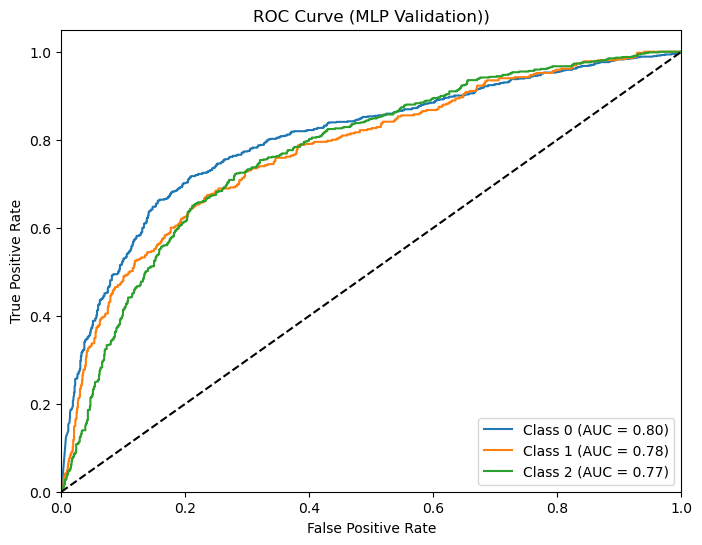

In [26]:
# Set random seed for reproducibility
torch.manual_seed(42)

# define the mlp model
class contraceptiveNN(nn.Module):
    def __init__(self, hidden1,hidden2): # constructor method for contructiveNN class with hidden neuron sizes as params
        super(contraceptiveNN, self).__init__() # constructor method for parent class to initialize
        self.fc1 = nn.Linear(9, hidden1) # fully connected linear layer, takes 9 inputs
        self.fc2 = nn.Linear(hidden1, hidden2)  # second fully connected linear layer
        self.fc3 = nn.Linear(hidden2, 3) # third linear layer
        #self.fc4 = nn.Linear(hidden3, hidden4)
        #self.fc5 = nn.Linear(hidden4, hidden5)
        #self.fc6 = nn.Linear(hidden5, 3)
        self.relu = nn.ReLU() # rectified linear unit activation function
        self.softmax = nn.Softmax(dim=1) # softmax layer for classification task

    # implement forward pass    
    def forward(self, x):
        x = self.fc1(x) # applies first fully connected linear layer to input x
        x = self.relu(x) # applies relu activation function to output of fc1
        x = self.fc2(x) # applies fc2  to x
        x = self.relu(x) # apply relu activation function
        x = self.fc3(x) # apply fc3 to x
        #x = self.relu(x)
        #x = self.fc4(x)
        #x = self.relu(x)
        #x = self.fc5(x)
        #x = self.relu(x)
        #x = self.fc6(x)
        x = self.softmax(x)  # apply softmax
        return x # returns output

# best parameters from grid search
best_params = {'hidden_size1': 70, 'hidden_size2': 90, 'learning_rate': 0.01, 'weight_decay': 0.001}

# num of epochs
num_epochs = 500

# create mlp model with best parameters
model = contraceptiveNN(hidden1=best_params['hidden_size1'], hidden2=best_params['hidden_size2'])

# create adam optimizer with parameters from grid search
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])

# create cross entropy loss function
criterion = nn.CrossEntropyLoss()

# k fold cross validation
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# create variables to store accuracy and training time
total_accuracy = 0
total_training_time = 0

# Create arrays to store predictions and true labels from all folds
all_y_true = []
all_y_pred = []
all_y_score = []
all_confusion_matrices = []

# k fold cross validation
for fold, (train_idx, test_idx) in enumerate(skf.split(x_train, y_train.argmax(axis=1))):

    # split into training and validation set
    x_train_fold, y_train_fold = x_train[train_idx], y_train[train_idx]
    x_val, y_val = x_train[test_idx], y_train[test_idx]

    # convert to tensors
    x_train_fold = torch.tensor(x_train_fold, dtype=torch.float32)
    y_train_fold = torch.tensor(y_train_fold.argmax(axis=1), dtype=torch.long)
    x_val = torch.tensor(x_val, dtype=torch.float32)
    y_val = torch.tensor(y_val.argmax(axis=1), dtype=torch.long)
    
    # start recording time for training speed
    start_time = time.time() 

    # backpropagation
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        y_pred = model(x_train_fold)
        loss = criterion(y_pred, y_train_fold)
        loss.backward()
        optimizer.step()

    # end recording time for training speed
    end_time = time.time()  
    # total training time
    total_training_time += (end_time - start_time)  

    # evaluate on validation set for current fold
    test_outputs = model(x_val)
    _, predicted = torch.max(test_outputs, 1)

    # getaccuracy
    correct = (predicted == y_val).sum().item()
    total = y_val.size(0)
    accuracy = correct / total
    total_accuracy += accuracy

    # store results
    all_y_true.extend(y_val.tolist())
    all_y_pred.extend(predicted.tolist())
    all_y_score.extend(test_outputs.tolist())

    # get confusion matrix for current fold
    confusion_matrix_fold = confusion_matrix(y_val, predicted)
    all_confusion_matrices.append(confusion_matrix_fold)

    print(f'Fold {fold + 1}, Accuracy: {accuracy}')

# get average accuracy
avg_accuracy = total_accuracy / k_folds
print(f"Average Accuracy: {avg_accuracy}")
print(f"Average Training Time per fold: {total_training_time / k_folds} seconds")

# convert to arrays for classification report and confusion matrix
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_score = np.array(all_y_score)

# get average confusion matrix across all folds
avg_confusion_matrix = np.mean(all_confusion_matrices, axis=0)
print("Average Confusion Matrix:")
print(avg_confusion_matrix)


# code reference: https://ai.stackexchange.com/questions/42091/roc-curve-for-multiclassification-results-sound-not-correct    
# https://stackoverflow.com/questions/70278059/plotting-the-roc-curve-for-a-multiclass-problem
# calculate roc curve graph
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  
    fpr[i], tpr[i], _ = roc_curve(all_y_true == i, all_y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot roc curve
plt.figure(figsize=(8, 6))
for i in range(3):  
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (MLP Validation))')
plt.legend(loc="lower right")
plt.show()


In [27]:
from sklearn.metrics import classification_report

# get classification report for validation
print("Classification Report:")
print(classification_report(all_y_true, all_y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.72      0.72       803
           1       0.55      0.52      0.53       415
           2       0.62      0.65      0.64       666

    accuracy                           0.65      1884
   macro avg       0.63      0.63      0.63      1884
weighted avg       0.65      0.65      0.65      1884



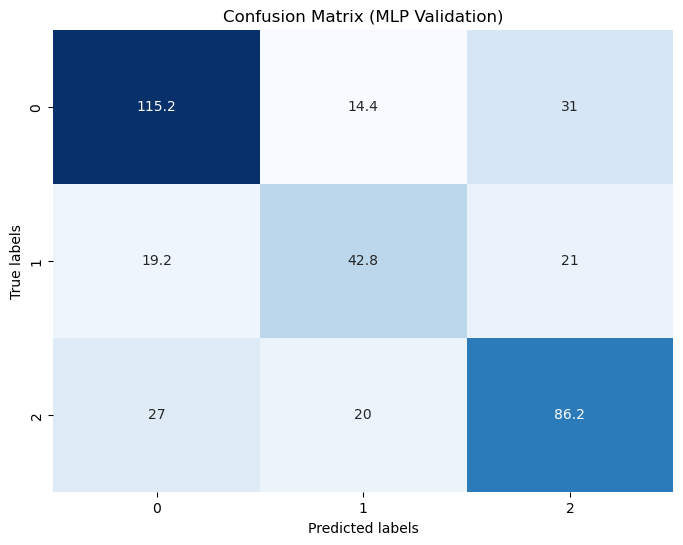

In [29]:
import seaborn as sns

# create average confusion matrix
avg_confusion_matrix = np.mean(all_confusion_matrices, axis=0)

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(avg_confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (MLP Validation)')
plt.show()

# Test model

In [31]:

# wrap data in tensors
#x_test = torch.tensor(x_test, dtype=torch.float32)
#y_test = torch.tensor(y_test.argmax(axis=1), dtype=torch.long)

# make predictions on test data
test_outputs = model(x_test)
_, predicted = torch.max(test_outputs, 1)

# get accuracy on test data
correct = (predicted == y_test).sum().item()
total = y_test.size(0)
test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy}")

# create and display classification report for the test data
print("Test Classification Report:")
print(classification_report(y_test, predicted))

# create and display confusion matrix for the test data
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, predicted))


Test Accuracy: 0.6504237288135594
Test Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.70      0.72       195
           1       0.59      0.47      0.52       109
           2       0.60      0.71      0.65       168

    accuracy                           0.65       472
   macro avg       0.64      0.63      0.63       472
weighted avg       0.65      0.65      0.65       472

Test Confusion Matrix:
[[137  16  42]
 [ 21  51  37]
 [ 29  20 119]]


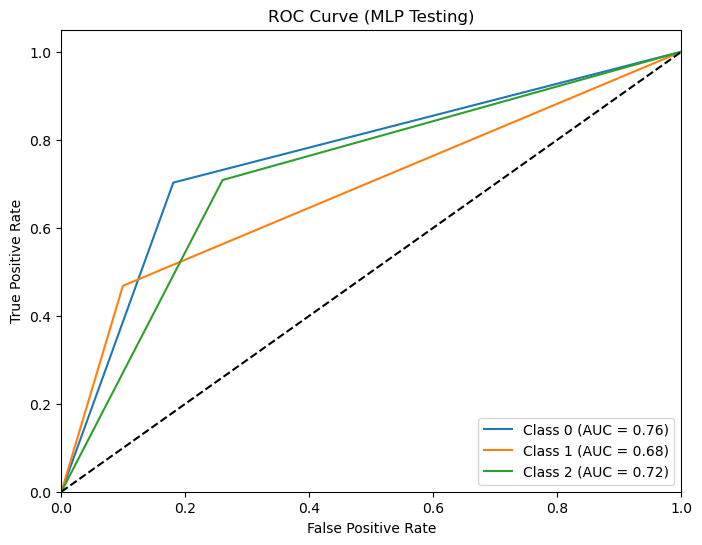

In [39]:
# code reference: https://ai.stackexchange.com/questions/42091/roc-curve-for-multiclassification-results-sound-not-correct    
# https://stackoverflow.com/questions/70278059/plotting-the-roc-curve-for-a-multiclass-problem
# get roc curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3): 
    fpr[i], tpr[i], _ = roc_curve(y_test == i, predicted == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot roc curve
plt.figure(figsize=(8, 6))
for i in range(3): 
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (MLP Testing)')
plt.legend(loc="lower right")
plt.show()


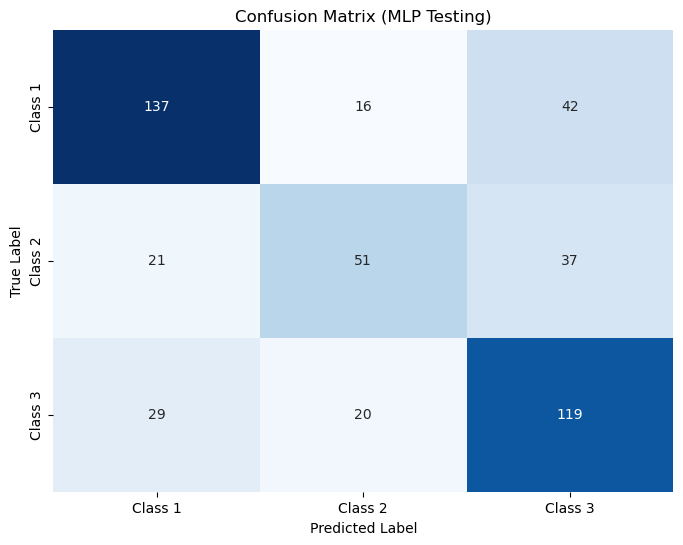

In [38]:
#y_pred_class = np.argmax(y_pred_np, axis=1)

# create confusion matrix for testing
cm = confusion_matrix(y_test, predicted)

# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, 
            xticklabels=['Class 1', 'Class 2', 'Class 3'], 
            yticklabels=['Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (MLP Testing)')
plt.show()

In [33]:
torch.save(model.state_dict(), 'final_mlp_model.pth') #save model

In [34]:
x_test_df = pd.DataFrame(x_test)
y_test_df = pd.DataFrame(y_test)

x_test_df.to_csv('mlp_x_test.csv', index=False)
y_test_df.to_csv('mlp_y_test.csv', index=False)

### Go to testing_reproducibility.ipynb to reproduce test results